**NB :** Ceci est un notebook interactif. Vous pouvez modifier les valeurs ou intéragir avec les graphiques.

Pensez à (re)valider les cellules si ça n'est pas fait automatiquement au lancement : **Maj+Entrer** ou **Cell >> Run All**

In [1]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events),on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Math,HTML
from scipy.stats import norm,lognorm
from itertools import permutations
from scipy import linalg,optimize
from pyvalem.formula import Formula 

from pint import UnitRegistry
unit = UnitRegistry(preprocessors=[lambda x: x.replace("%", " percent ")])
unit.set_fmt_locale('fr_FR')
unit.define('fraction = [] = frac')
unit.define('percent = 1e-2 frac = pct')
unit.define('ppm = 1e-6 fraction')

In [4]:
def compute_EF(var_EF):
    return np.sqrt(var_EF)
def compute_std(tA,EF):
    return tA*EF
def confidence2n_std(confidence):
    return norm().isf((1-confidence/100)/2)
def n_std2confidence(n_std=1):
    return 100-(1-norm().cdf(n_std))*2*100
def compute_confidence_range(tA,std,confidence):
    n=confidence2n_std(confidence)
    return tA + np.multiply([-1,1],n*std)
def compute_confidence_range_from_EF(tA,EF,confidence):
    return compute_confidence_range(tA,compute_std(tA,EF),confidence)
def compute_confidence_range_from_var_EF(tA,var_EF,confidence):
    return compute_confidence_range_from_EF(tA,compute_EF(var_EF),confidence)
def compute_EF_from_confidence_range(plus_or_minus,tA,confidence,verbose=True):
    if verbose: print("Using a confidence interval gathering {}% of possible values".format(confidence))
    n = confidence2n_std(confidence)
    if verbose: print("This confidence range corresponds to {:.2f} standard deviations".format(n))
    std = plus_or_minus / n
    if verbose: print("The standard deviation is {:} ".format(std))
    EF = std/tA
    if verbose: print("Thus EF is {:} ".format(EF))
    return EF

In [5]:
def compute_sample_mass_factor(Me,ML=None):
    if ML is None:
        return 1/Me
    else:
        return 1/Me - 1/ML
def mass_factor_simplification_overestimate_perc(Me,ML):
    return (1/ML)/(1/Me - 1/ML)*100

In [6]:
def compute_composition_factor(tA,rhoA,rhoG):
    return (1-tA)/tA*((1-tA)*rhoA + tA*rhoG)

In [7]:
def compute_d(granulo,mass,perc):
    cum = np.cumsum(mass)
    cum = cum/cum[-1]
    perc = (100-perc)/100
    first = np.argwhere(cum > perc).ravel()[0]
    if first>0:
        seg = first-1
        alpha = (perc-cum[seg])/(cum[seg+1]-cum[seg])
        return [(1-alpha)*granulo[seg] + alpha*granulo[seg+1],
                (1-alpha)*mass[seg] + alpha*mass[seg+1]]
    else:
        return [granulo[0],mass[0]]

In [8]:
def compute_granulometry_factor(d5=None,d95=None):
    if d5 is None or d95 is None:
        return 0.25
    ratio  = d5/d95
    if ratio == 1:
        return 1
    elif ratio < 2:
        return 0.75
    elif ratio < 4:
        return 0.5
    else:
        return 0.4

In [9]:
def compute_liberation_factor(d5,dl):
    return np.where(d5<=dl,1,np.sqrt(dl/d5))

In [10]:
shape_factor={
    "cube":1,
    "sphere":np.pi/6,
    "flake":0.2,
    "default":0.5
}
def compute_volumetric_effect(d,shape="default"):
    return shape_factor[shape]*d**3

In [11]:
def transform_grade_to_mineral(te,element,mineral,verbose=True):
    molar_mass_element = Formula(element).rmm
    molar_mass_mineral = Formula(mineral).rmm
    stoechio = Formula(mineral).atom_stoich[element]
    
    tA = te/stoechio/molar_mass_element*molar_mass_mineral
    if verbose: print("Pour une teneur en {} de {:.2f}% on a une teneur en {} de {:.2f}%".format(element,te*100,mineral,tA*100))
    return tA
def transform_mineral_to_grade(tA,element,mineral,verbose=True):
    molar_mass_element = Formula(element).rmm
    molar_mass_mineral = Formula(mineral).rmm
    stoechio = Formula(mineral).atom_stoich[element]
    
    te = tA*stoechio*molar_mass_element/molar_mass_mineral
    if verbose: print("Pour une teneur en {} de {:.2f}% on a une teneur en {} de {:.2f}%".format(mineral,tA*100,element,te*100))
    return te

def compute_factors(d5,tA,rhoA,rhoG,dl,d95=None,shape="default",verbose=True):
    if verbose: print("Calculs des facteurs contribuants à l'erreur fondamentale")
    composition_factor = compute_composition_factor(tA=tA,rhoA=rhoA,rhoG=rhoG)
    if verbose: print("  Composition factor: c={:.4f}".format(composition_factor))
    granulo_factor = compute_granulometry_factor(d5,d95)
    if verbose: print("  Granulometric factor: g={:.4f}".format(granulo_factor))
    liberation_factor = compute_liberation_factor(d5=d5,dl=dl)
    if verbose: print("  Liberation factor: l={:.4f}".format(liberation_factor))
    
    volumetric_factor = compute_volumetric_effect(d5,shape)
    if verbose: print("  Shape factor: f={}".format(shape_factor[shape]))
    if verbose: print("  Volumetric factor: fd**3={:.4f}".format(volumetric_factor))
    
    return composition_factor * granulo_factor * liberation_factor * volumetric_factor
    
def compute_EF(Me,d5,tA,rhoA,rhoG,dl,d95=None,shape="default",ML=None,verbose=True,confidence_perc=n_std2confidence()):
    mass_factor = compute_sample_mass_factor(Me,ML)
    if verbose: print("Mass factor: 1/Me - 1/ML =",mass_factor)
    
    var_relative = mass_factor * compute_factors(d5,tA,rhoA,rhoG,dl,d95,shape,verbose)
    if verbose:
        print("The estimated relative variance: {}".format(var_relative))
    if verbose: print("Using a confidence interval gathering {}% of possible values".format(confidence_perc))
    n = confidence2n_std(confidence_perc)
    if verbose: print("This confidence range corresponds to {:.2f} standard deviations".format(n))
    EF = n*np.sqrt(var_relative)
    if verbose: print("The Fondamental Error (EF) is {:0.2f}%".format(EF*100))
    return EF

def compute_sample_mass(EF,d5,tA,rhoA,rhoG,dl,d95=None,shape="default",ML=None,verbose=True,confidence_perc=n_std2confidence()):
    """
    EF (%): is the relative error with a confidence interval given by confidence_perc
    d5 (cm): size of the largest particles 
    tA : grade in terms of mineral A
    rhoA and rhoG (g/cm^3): volumetric mass of mineral A and bulk
    dl (cm): liberation size
    result in g
    """
    
    if verbose: print("Using a confidence interval gathering {}% of possible values".format(confidence_perc))
    n = confidence2n_std(confidence_perc)
    if verbose: print("This confidence range corresponds to {:.2f} standard deviations".format(n))
    var_relative = (EF/n)**2
    if verbose:
        print("With a Fondamental error (EF) of: {}".format(EF))
        print("Target relative variance: {}".format(var_relative))
    
    M = 1/var_relative * compute_factors(d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,d95=d95,shape=shape,verbose=verbose)
    Me = M
    if ML is not None:
        Me = M*ML/(M+ML)
    if verbose:
        if M >10**6:
            print("Sample mass: {:.3f}t".format(Me/10**6))
        elif M >10**3:
            print("Sample mass: {:.3f}kg".format(Me/10**3))
        else:
            print("Sample mass: {:.3f}g".format(Me))
    return Me

In [13]:
def compute_aspect_ratio(ax):
    xlim = ax.get_xlim() if ax.get_xscale() == "linear" else np.log10(ax.get_xlim())
    ylim = ax.get_ylim() if ax.get_yscale() == "linear" else np.log10(ax.get_ylim())
    ## Axis size on figure
    figW, figH = ax.get_figure().get_size_inches()
    ## Ratio of display units
    _, _, w, h = ax.get_position().bounds
    ##final aspect ratio
    return ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

# Echantillonnage : Dissection de la formule simplifiée de Pierre Gy

La formule simplifiée de Pierre Gy permet d'estimer la variance de l'erreur fondamentale lors d'un échantillonnage.

$\large \sigma_{EF}^2=\left(\frac{1}{M_e}-\frac{1}{M_L}\right) 𝑐 𝑔 𝑙 𝑓 𝑑^3 $

Elle permet de se concentrer sur l'effet :
1. de la masse de l'échantillon prélevé ($M_e$) et 
2. la maille granulométrique prélevée (représentée par les facteurs $𝑔 𝑙 𝑓 𝑑^3$, voir détails ci-dessous)
3. la teneur n'influe finalement que sur le paramètre $c$

## Explications détaillées

Dans cette formule. on considère la teneur d'un élément chimique ($t_e$) présents au sein d'une phase minérale ($A$) prise dans une gangue qui regroupe tout le reste ($G$). 

Les blocs ci-dessous vont vous permettre de comprendre la signification et l'impact de chacun de ces facteurs :
* $\sigma_{EF}^2$ est la variance de l'erreur fondamentale (relative).<br>Cette variance relative permet de déduire un écart-type absolu $\sigma=t_A\sqrt{\sigma_{EF}^2}$, en le rapportant à la teneur en minéral $t_A$.
<br>Un interval de confiance de $\pm 2 \sigma$ permet d'encadrer 95% des incertitudes.<br>La valeur réelle a donc 95% de chance d'être dans une gamme $\left[t_A-2\sigma,t_A+2\sigma\right]$
* $M_e$ et $M_L$ représentent les masses de l'échantillon et du lot estimé. En pratique, on considèrera souvent le lot comme très grand par rapport à l'échantillon. donc on peut en faire abstraction : $\left(\frac{1}{M_e}-\frac{1}{M_L}\right)\approx\frac{1}{M_e}$ 
* $c$ : est un facteur de composition : $c =\left(\frac{1-t_A}{t_A}\right)\big[(1-t_A)\rho_A + t_A \rho_G\big]$. où $\rho_A$ est la masse volumique du minéral d'intérêt et $\rho_G$ celle de la gangue
* $g$ : est un facteur de distribution qui prend en compte la répartition de la granulométrie. Ce facteur dépend des dimensions $d_{5\%}$ et $d_{95\%}$.
 * Cette notation $d_{i\%}$ décrit la taille de maille retenant $i\%$ de sa masse. 
 * $d_{5\%}$ est donc une taille assez grande qui ne retient que les 5%(en masse) des grains les plus gros 
 * $d_{95\%}$ est une taille plus petite qui retient 95% de la masse, donc quasiment l'ensemble des grains des grains. sauf les 5\% de masse représentée par la fraction la plus fine.
* $l$ : est le facteur de libération. Il permet de tenir compte du fait que les minéraux d'intérêts (A) sont au départ pris dans la gangue. Plus les grains sont broyés fins et plus il y a de chance que le minéraux A se retrouvent complètement libéré de leur gangue. 
 * $d_l$ : est la dimension de libération commençante. i.e., la taille à laquelle les particules auront libéré 5% des minéraux A. En d'autres termes. si on réduit des grains à cette taille de manière homogène. 5% de la masse des minéraux A sera libre. 95% sera toujours attaché à des minéraux de gangue.
 * $l$ varie entre 0 et 1 : à 0 la libération est nulle, à 1 elle est totale
 * si $d_{5\%}\leq d_l$, on prendra : $l=1$ (95% des grains doivent être plus fin que $d_l$ donc 95% de A est libéré, on considère qu'on a atteint la maille de libération)
 * si $d_{5\%}> d_l$, on considèrera : $l=\sqrt{\frac{d_l}{d_{5\%}}}$ (moins de 95% des A sont libres la libération n'est donc que trop partielle, ce dont tient compte $l$)
* $f 𝑑^3$ : rend compte du volume des particules : 
 * $d$ correspond au diamètre des particules les plus grossières, en pratique on prend $d=d_{5\%}$.
 * $f$ est un facteur de forme. C'est le coefficient à appliquer pour passer d'une taille au cube à un volume :
  * pour des particules cubiques : $d$ représente le côté, donc le volume est $d^3$, ce qui correspond à $f=1$
  * pour des particules sphériques : $d$ représente le diamètre, donc le volume est $\frac{4}{3}\pi\left(\frac{d}{2}\right)^3 = \frac{\pi}{6}d^3$, ce qui correspond à $f=\frac{\pi}{6}=0.5236$
  * pour des particules allongées, e.g., l'or alluvial, on pourra prendre $f=0.2$
  * par défaut, si on ne connait pas la forme des particules on considèrera qu'elles sont proches de sphère : $f=0.5$

## Visualisation de l'effet des différents paramètres

### Visualisation de l'effet de $\sigma_{EF}^2$ et des teneurs $t_A$ et $t_e$
$\sigma_{EF}^2$ est la variance de l'erreur fondamentale (relative).
<br>Cette variance relative permet de déduire un écart-type absolu $\sigma=t_A\sqrt{\sigma_{EF}^2}$. en le rapportant à la teneur en minéral $t_A$.

Un interval de confiance de $\pm 2 \sigma$ permet d'encadrer 95% des incertitudes. La valeur réelle a donc 95% de chance d'être dans une gamme $\left[t_A-2\sigma.t_A+2\sigma\right]$

In [14]:
def annotate_sigma(dist,n_sigma,ax):
    height = 0.16*(1-(abs(n_sigma)-1)/2)+0.02
    ax.annotate("", xy=(dist.mean()-n_sigma*dist.std(), height), xytext=(dist.mean(), height),
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax.text(dist.mean()-n_sigma*dist.std()/2, height, r'{}$\sigma$'.format(abs(n_sigma) if abs(n_sigma)>1 else ""),
             {'color': 'black', 'fontsize': 16, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.2)})

perc={}
perc[1]=68
perc[2]=95
perc[3]=99.7
def annotate_perc(dist,n_sigma,ax):
    height = 0.15*(1-(abs(n_sigma)-1)/2)+0.005
    ax.annotate("", xy=(dist.mean()-n_sigma*dist.std(), height),
                 xytext=(dist.mean()+n_sigma*dist.std(), height),
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))

    ax.text(dist.mean(), height, "{}%".format(perc[n_sigma]),
             {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.2)})    

@interact(te=widgets.FloatSlider(min=0.001,max=0.999,step=0.001,value=0.1,continuous_update=False,description="$t_{e|A}$ : la teneur en élément cible dans le minéral d'intérêt"),
          tA=widgets.FloatSlider(min=0.001,max=0.999,step=0.001,value=0.1,continuous_update=False,description="$t_A$ : la proportion massique de minéral d'intérêt dans le lot"),
          EF_perc=widgets.IntSlider(min=1,max=100,step=1,value=10,continuous_update=False,description="$EF_{\%}$ : l'erreur fondamentale en %"),
          confidence=widgets.FloatSlider(min=50,max=99.99,value=95.45,step=0.01,continuous_update=False,description="Le niveau de confiance (e.g.. 95%)"),
          show_switch=widgets.Dropdown(options=["minéral porteur","élément d'intérêt"],description='Teneur en :'))
def interact_confidence_range(te,tA,EF_perc,confidence,show_switch):
    fig,ax = plt.subplots(1,2)

    N_4_2 = norm(loc=4,scale=2)
    range_min,range_max = [-3,11]
    x= np.linspace(range_min,range_max,100)
    ax[0].plot(x,N_4_2.pdf(x))
    ax[0].axvline(x=N_4_2.mean(),color='r')
    ax[0].axvline(x=N_4_2.mean()-N_4_2.std(),color='r',linestyle="--",ymax=0.9)
    ax[0].axvline(x=N_4_2.mean()+N_4_2.std(),color='r',linestyle="--",ymax=0.9)
    ax[0].axvline(x=N_4_2.mean()-2*N_4_2.std(),color='gray',linestyle="--",ymax=0.5)
    ax[0].axvline(x=N_4_2.mean()+2*N_4_2.std(),color='gray',linestyle="--",ymax=0.5)
    ax[0].axvline(x=N_4_2.mean()-3*N_4_2.std(),color='gray',linestyle="--",ymax=0.125)
    ax[0].axvline(x=N_4_2.mean()+3*N_4_2.std(),color='gray',linestyle="--",ymax=0.125)
    annotate_sigma(N_4_2,-1,ax[0])
    annotate_sigma(N_4_2,1,ax[0])
    annotate_sigma(N_4_2,-2,ax[0])
    annotate_sigma(N_4_2,2,ax[0])
    annotate_sigma(N_4_2,-3,ax[0])
    annotate_sigma(N_4_2,3,ax[0])
    annotate_perc(N_4_2,1,ax[0])
    annotate_perc(N_4_2,2,ax[0])
    annotate_perc(N_4_2,3,ax[0])
    
    ax[0].set_title("Gamme d'incertitude en fonction du nombre d'écart-type")

    tA = tA if show_switch == "minéral porteur" else tA*te
    scale_factor = 1/100
    sigma = tA*EF_perc * scale_factor
    range_min,range_max = compute_confidence_range(tA,sigma,confidence)
    N = norm(loc=tA,scale=sigma)
    x= np.linspace(tA-4*sigma,tA+4*sigma,1000)
    pdf = N.pdf(x)
    ax[1].set_ylim(0,1.05*N.pdf(tA))
    ax[1].plot(x / scale_factor,pdf,label="Distribution de probabilité de "+r"$t_A$")
    ax[1].axvline(x=tA / scale_factor,color='g',linestyle="-",ymax=0.99,label="Estimation")
    ax[1].axvline(x=range_min / scale_factor,color='r',linestyle="--",ymax=0.9,label="Interval de confiance à {}".format(confidence))
    ax[1].axvline(x=range_max / scale_factor,color='r',linestyle="--",ymax=0.9)
    
    handles,labels = ax[1].get_legend_handles_labels()
    handles.append(patches.Patch(color='none', label="Erreur fondamentale (EF) : {}%".format(EF_perc)))
    handles.append(patches.Patch(color='none', label="Variance d'erreur fondamentale : {}={:.3f}".format(r"$\sigma_{EF}2$",(EF_perc/100)**2 )))
    ax[1].legend(handles=handles)

    graph_max = max(0.5 if show_switch == "minéral porteur" else 0.1,1.5*range_max)/scale_factor
    ax[1].set_xlim(0,graph_max)
    ax[1].set_xticks(np.arange(0,graph_max,10 if show_switch == "minéral porteur" else 1))
    ax[1].set_xlabel("Teneur en "+show_switch+" (en %masse)")
    
    ax[1].set_title("Gamme d'incertitude en teneur ({})".format(show_switch))
    
    fig.set_size_inches((16,4))

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description="$t_{e|A}$ : la teneur en él…

**A vous de jouer** : Faites varier l'interval de confiance et les teneurs pour voir leurs influences sur l'erreur absolue.

### Visualisation de l'effet de la masse de l'échantillon $M_e$

$M_e$ et $M_L$ représentent les masses de l'échantillon et du lot estimé.<br>En pratique. on considèrera souvent le lot comme très grand par rapport à l'échantillon. donc on peut en faire abstraction : $\left(\frac{1}{M_e}-\frac{1}{M_L}\right)\approx\frac{1}{M_e}$

In [18]:
@interact(ML=widgets.FloatLogSlider(min=0,max=6,step=0.2,value=50,description="Masse du lot",continuous_update=False))
def interact_mass_effect(ML):
    Me_x = np.linspace(1,1*ML,100)

    fig,ax = plt.subplots(1,2)
    ax[0].set_title("Effet de la masse de l'échantillon")
    ax[0].set_ylabel("Erreur fondamentale relative normalisée (%)")
    ax[0].plot(Me_x,compute_sample_mass_factor(Me_x),label="sans considérer la masse du lot")
    ax[0].plot(Me_x,compute_sample_mass_factor(Me_x,ML=ML),label="en considérant un lot de {:.2f}g".format(ML))
    ax[0].set_xlabel("Masse de l'échantillon (Me) en g")
    ax[0].set_yticks(np.arange(0.1,1.10,0.1))
    ax[0].set_yticklabels(np.arange(10,110,10))
    ax[0].legend()
    
    Me_x = np.linspace(1,0.75*ML,100)
    ax[1].set_title("Surestimation de l'erreur du à la simplification de "+r"$M_L$: $\frac{1/M_L}{1/M_e - 1/M_L}$")
    ax[1].set_ylabel("Portion de l'Erreur fondamentale surestimée")
    overestimates = mass_factor_simplification_overestimate_perc(Me_x[:-1],ML)
    ax[1].plot(Me_x[:-1],overestimates)
    ax[1].set_xlabel("Masse de l'échantillon (Me) en g")
    ax[1].set_yticks(np.append([0,20,50,75],np.arange(100,overestimates.max(),100)))
    
    fig.set_size_inches((16,4))
    

interactive(children=(FloatLogSlider(value=50.0, continuous_update=False, description='Masse du lot', max=6.0,…

L'augmentation de la masse d'échantillon fait rapidement chuter l'erreur fondamental (i.e., l'incertitude).

Le fait d'ignorer la masse du lot est négligeable tant que l'échantillon reste petit par rapport au lot.<br>

**A vous de jouer** : A combien s'élève cette surestimation pour un échantillon représentant 10% de la masse du lot ?

### Visualisation de l'effet du facteur de composition $c$

Le facteur de composition $c$ prend en compte la proportion de minéraux d'intérêt dans l'ensemble 

$c =\left(\frac{1-t_A}{t_A}\right)\big[(1-t_A)\rho_A + t_A \rho_G\big]$. où :
* $t_A$ est la proportion massique de minéraux d'intéret
* $\rho_A$ est la masse volumique du minéral d'intérêt
* $\rho_G$ est la masse volumique de la gangue

In [30]:
@interact(rho_A = widgets.FloatSlider(min=1,max=15,step=0.1,value=5,description=r"$\rho_A$: Masse volumique A (g/cm^3)",continuous_update=False),
         rho_G = widgets.FloatSlider(min=1,max=15,step=0.1,value=3,description=r"$\rho_G$: Masse volumique G (g/cm^3)",continuous_update=False))
def interact_composition_factor(rho_A,rho_G):
    tA_x = np.linspace(0,1,100)[1:]
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(tA_x,compute_composition_factor(tA_x,rho_A,rho_G))
    axes[0].set_title("Effet du facteur de composition")
    axes[0].set_ylabel("Facteur de composition ($c$)")
    axes[0].set_xlabel("Proportion massique de A dans le lot")
    
    axes[1].loglog(tA_x,compute_composition_factor(tA_x,rho_A,rho_G) )
    axes[1].set_title("Effet du facteur de composition")
    axes[1].set_ylabel("Log Facteur de composition ($c$)")
    axes[1].set_xlabel("Log Proportion massique de A dans le lot")
    fig.set_size_inches((14,6))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='$\\rho_A$: Masse volumique …

Attention. $t_A$ est bien la proportion massique de minéraux et non de l'élement chimique recherché. Il faut mettre ces deux quantités en relation par : 

$t_e = t_{e|A}\cdot t_{A} \hspace{2cm}  t_A = \frac{t_{e}}{t_{e|A}} \hspace{2cm}$ avec :<br> 
* $t_e$ : la teneur massique en élément $e$ dans le matériau
* $t_A$ : la teneur massique de minéraux $A$ dans le matériau
* $t_{e|A}$ : la teneur massique (i.e.. proportion en masse) de l'élément $e$ dans $A$



$t_{e|A}$ peut s'estimer grâce à la formule chimique du minéral porteur et aux masses molaires. Par exemple pour la chalcopyrite ($CuFeS_2$):

$t_{Cu|CuFeS_2} = \frac{\mathrm{M}_{Cu}}{\mathrm{M}_{Cu}+\mathrm{M}_{Fe}+2\cdot \mathrm{M}_S}$

**A vous de jouer** : Dans quelle configuration ce facteur est il le plus fort ? Quel est l'influence de la proportion massique, de la masse volumiquer de la gangue, du minerais ?

### Visualisation de l'effet du facteur de granulométrie $g$

$g$ est un facteur de distribution qui prend en compte la répartition de la granulométrie.

Ce facteur dépend des dimensions $d_{5\%}$ et $d_{95\%}$.
 * Cette notation $d_{i\%}$ décrit la taille de maille retenant $i\%$ de sa masse. 
 * $d_{5\%}$ est donc une taille assez grande qui ne retient que les 5%(en masse) des grains les plus gros 
 * $d_{95\%}$ est une taille plus petite qui retient 95% de la masse, donc quasiment l'ensemble des grains des grains, sauf les 5% de masse représentée par la fraction la plus fine.
 
$g$ est fixé suivant ce tableau :

| $\frac{d_{5\%}}{d_{95\%}}$ | $g$ | 
|----------------------|-----|
|   >4  | 0.4    |
|   2< ... < 4  | 0.5    |
|   1< ... < 2  | 0.75    |
|    1 | 1|

Si $d_{5\%}$ et $d_{95\%}$ ne sont pas connus on prendra $g = 0.25$

In [31]:
@interact(d5=widgets.IntSlider(min=1,max=100,value=90,step=1),
         d95=widgets.IntSlider(min=1,max=100,value=10,step=1))
def interact_g(d5,d95):
    if d5<d95:
        print("d5% doit être plus grand que d95%")
    else:
        print("Le facteur de granulométrie g vaut :",compute_granulometry_factor(d5,d95))

interactive(children=(IntSlider(value=90, description='d5', min=1), IntSlider(value=10, description='d95', min…

In [36]:
@interact(perc=widgets.IntSlider(min=1,max=99,step=1,value=50,description=r"$d_{\%}$",continuous_update=False))
def interact_d(perc):
    granulo_limits = np.array([0,0.04,0.08,0.16,0.315,0.63,1.25,2.5,5,12.5,20,40])
    granulo_center = 0.5*(granulo_limits[:-1]+granulo_limits[1:])
    granulo_mass = np.array([198,150,184,106,89.2,98,83.7,23.7,14.8,13.3,39.3])[::-1]
    plt.semilogx(granulo_center,granulo_mass)
    plt.title("Répartition granulométrique")
    plt.xlabel("Granulométrie (mm)")
    plt.ylabel("Masse (g)")

    d5,mass5 = compute_d(granulo_center,granulo_mass,5)
    plt.plot([d5,d5],[0,mass5],"k--")
    plt.text(d5,mass5*1.15,r"$d_{"+"{}".format(5)+"\%}$",
             {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.15)})
    d95,mass95 = compute_d(granulo_center,granulo_mass,95)
    plt.plot([d95,d95],[0,mass95],"k--")
    plt.text(d95,mass95*1.15,r"$d_{"+"{}".format(95)+"\%}$",
             {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.15)})
    
    d,mass = compute_d(granulo_center,granulo_mass,perc)
    plt.plot([d,d],[0,mass])
    granulo_fill = np.append([d],granulo_center[granulo_center>d])
    mass_fill = np.append([mass],granulo_mass[granulo_center>d])
    plt.fill_between(granulo_fill,mass_fill,0)
    plt.text(d,mass*1.15,r"$d_{"+"{}".format(perc)+"\%}$",
             {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.2)})
    
    print("Sur cet exemple:\n - d5% vaut {:.2f},\n - d95% vaut {:.2f},\n - d5/d95 vaut donc {:.2f}\n - et g: {}".format(d5,d95,d5/d95, compute_granulometry_factor(d5,d95)))


interactive(children=(IntSlider(value=50, continuous_update=False, description='$d_{\\%}$', max=99, min=1), Ou…

Attention, ce paramètre peut être contre-intuitif. C'est bien la maille qui retient n% de la masse.

$d_{5\%}$ est donc une borne relativement haute de la gamme de granulométrie, alors que $d_{95\%}$ représente la taille des plus petites particules.

### Visualisation de l'effet du facteur de libération $l$

$l$ : est le facteur de libération. Il permet de tenir compte du fait que les minéraux d'intérêts (A) sont au départ pris dans la gangue. Plus les grains sont broyés fins et plus il y a de chance que le minéraux A se retrouvent complètement libéré de leur gangue. 
 * $d_l$ : est la dimension de libération commençante. i.e., la taille à laquelle les particules auront libéré 5% des minéraux A. En d'autres termes. si on réduit des grains à cette taille de manière homogène. 5% de la masse des minéraux A sera libre. 95% sera toujours attaché à des minéraux de gangue.
 * $l$ varie entre 0 et 1 : à 0 la libération est nulle, à 1 elle est totale
 * si $d_{5\%}\leq d_l$, on prendra : $l=1$ (5% des grains doivent être plus gros que $d_l$ donc 95% de A est libéré , on considère qu'on a atteint la maille de libération)
 * si $d_{5\%}> d_l$, on considèrera : $l=\sqrt{\frac{d_l}{d_{5\%}}}$ (moins de 5% des A sont libres la libération n'est donc que trop partielle, ce dont tient compte $l$)

Le broyage permet de réduire la taille des grains et diminue donc $d_{5\%}$.

In [37]:
@interact(dl=widgets.FloatLogSlider(min=-3,max=3,value=1,step=0.1,description="dl: Maille de libération commençante (mm)",continuous_update=False),
         d5=widgets.FloatLogSlider(min=-3,max=3,value=2,step=0.1,description="d5 (mm)",continuous_update=False))
def interact_liberation(dl,d5):
    d_x = 10**np.linspace(-3,3,1000)
    plt.semilogx(d_x, compute_liberation_factor(d_x,dl))
    plt.title("Effet du facteur de libération")
    plt.ylabel("Contribution de l")
    plt.xlabel("$d_{5\%}$ (mm)")
    plt.ylim(0,1.05)
    plt.axvline(x=dl,color='r',linestyle="--",ymax=0.98,label="dl")
    
    l=compute_liberation_factor(d5,dl)
    plt.scatter(d5,l,color="r")
    plt.semilogx([d5,d5],[0,l],"r-",label="$d_{5\%}$") 
    
    handles,labels = plt.gca().get_legend_handles_labels()
    handles.append(patches.Patch(color='none', label="l={:0.2f}".format(l)))
    plt.legend(handles=handles)


interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='dl: Maille de libération…

### Visualisation de l'effet volumetrique

$f 𝑑^3$ : rend compte du volume des particules : 
 * $d$ correspond au diamètre des particules le splus fines, en pratique on prend $d=d_{95\%}$.
 * $f$ est un facteur de forme. C'est le coefficient à appliquer pour passer d'une taille au cube à un volume :
  * pour des particules cubiques : $d$ représente le côté, donc le volume est $d^3$, ce qui correspond à $f=1$
  * pour des particules sphériques : $d$ représente le diamètre, donc le volume est $\frac{4}{3}\pi\left(\frac{d}{2}\right)^3 = \frac{\pi}{6}d^3$, ce qui correspond à $f=\frac{\pi}{6}=0.5236$
  * pour des particules allongées, e.g., l'or alluvial, on pourra prendre $f=0.2$
  * par défaut, si on ne connait pas la forme des particules on considèrera qu'elles sont proches de sphère : $f=0.5$

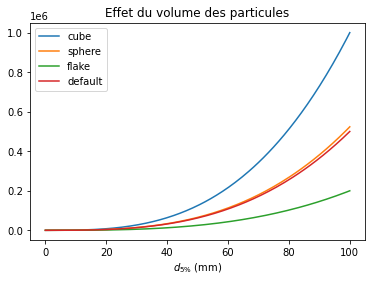

In [39]:
shape=["cube","sphere","flake","default"]
d_x = 10**np.linspace(-3,2,1000)
plt.xlabel("$d_{5\%}$ (mm)")
plt.title("Effet du volume des particules")
for shape_i in shape:
    plt.plot(d_x,compute_volumetric_effect(d_x,shape_i),label=shape_i)
l=plt.legend()


# Applications de la formule de Gy simplifiée

## Calculs d'incertitude

### Chacopyrite $t_{Cu}=0.8\%$

On considère un minerai de cuivre concassé à 12,5 mm présentant les caractéristiques suivantes :
* la teneur en cuivre ($t_{Cu}$) est de 0.8 % en masse
* le cuivre est porté par la chalcopyrite ($CuFeS_2$)
* les observations minéralogiques montrent que la maille de libération ($dl$) est de 0,01 cm
* les masses volumiques de la chalcopyrite et de sa gangue quartzeuse sont respectivement : $\rho_{CuFeS_2} = 4.2\ g/cm^3$ et $\rho_{Qz} = 2.65\ g/cm^3$

Quelle est la masse minimale de l'échantillon à prélever pour une erreur absolue de $\pm 0.05\ \% Cu$ ?

In [40]:
tCu = 0.8/100 #%Cu
d5 = 1.25 #cm
dl = 0.01 #cm
rhoCp = 4.2 #g/cm^3
rhoQz = 2.65 #g/cm^3
tCp = transform_grade_to_mineral(tCu,"Cu","CuFeS2")

delta_Cu = 0.05/100 #%Cu
delta_Cp = transform_grade_to_mineral(delta_Cu,"Cu","CuFeS2")
print("Une erreur absolue de {} %Cu représente une erreur absolue de {:.2f} %Chalcopyrite\n".format(delta_Cu*100,delta_Cp*100))
EF = compute_EF_from_confidence_range(delta_Cp,tCp,confidence=95)
mass = compute_sample_mass(EF=EF,d5=d5,tA=tCp,rhoA=rhoCp,rhoG=rhoQz,dl=dl,verbose=True)

Pour une teneur en Cu de 0.80% on a une teneur en CuFeS2 de 2.31%
Pour une teneur en Cu de 0.05% on a une teneur en CuFeS2 de 0.14%
Une erreur absolue de 0.05 %Cu représente une erreur absolue de 0.14 %Chalcopyrite

Using a confidence interval gathering 95% of possible values
This confidence range corresponds to 1.96 standard deviations
The standard deviation is 0.0007367086967999573 
Thus EF is 0.03188834105779087 
Using a confidence interval gathering 68.26894921370858% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.03188834105779087
Target relative variance: 0.001016866295417991
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=176.0823
  Granulometric factor: g=0.2500
  Liberation factor: l=0.0894
  Shape factor: f=0.5
  Volumetric factor: fd**3=0.9766
Sample mass: 3.781kg


### Chacopyrite $t_{Cu}=2.4\%$

On considère un minerai de cuivre concassé à 12,5 mm présentant les caractéristiques suivantes :
* la teneur en cuivre ($t_{Cu}$) est de 2.4 % en masse
* le cuivre est porté par la chalcopyrite ($CuFeS_2$)
* les observations minéralogiques montrent que la maille de libération ($dl$) est de 0,01 cm
* les masses volumiques de la chalcopyrite et de sa gangue quartzeuse sont respectivement : $\rho_{CuFeS_2} = 4.2\ g/cm^3$ et $\rho_{Qz} = 2.65\ g/cm^3$

Quelle est la masse minimale de l'échantillon à prélever pour une erreur absolue de $\pm 0.05\ \% Cu$ ?

In [41]:
tCu = 2.4/100 #%Cu
d5 = 1.25 #cm
dl = 0.01 #cm
rhoCp = 4.2 #g/cm^3
rhoQz = 2.65 #g/cm^3
tCp = transform_grade_to_mineral(tCu,"Cu","CuFeS2")

delta_Cu = 0.05/100 #%Cu
delta_Cp = transform_grade_to_mineral(delta_Cu,"Cu","CuFeS2")
print("Une erreur absolue de {} %Cu représente une erreur absolue de {:.2f} %Chalcopyrite\n".format(delta_Cu*100,delta_Cp*100))
EF = compute_EF_from_confidence_range(delta_Cp,tCp,confidence=95)
mass = compute_sample_mass(EF=EF,d5=d5,tA=tCp,rhoA=rhoCp,rhoG=rhoQz,dl=dl,verbose=True)

Pour une teneur en Cu de 2.40% on a une teneur en CuFeS2 de 6.93%
Pour une teneur en Cu de 0.05% on a une teneur en CuFeS2 de 0.14%
Une erreur absolue de 0.05 %Cu représente une erreur absolue de 0.14 %Chalcopyrite

Using a confidence interval gathering 95% of possible values
This confidence range corresponds to 1.96 standard deviations
The standard deviation is 0.0007367086967999573 
Thus EF is 0.010629447019263624 
Using a confidence interval gathering 68.26894921370858% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.010629447019263624
Target relative variance: 0.00011298514393533234
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=54.9562
  Granulometric factor: g=0.2500
  Liberation factor: l=0.0894
  Shape factor: f=0.5
  Volumetric factor: fd**3=0.9766
Sample mass: 10.621kg


### Minerai de fer $t_{Fe}=55.13\%$

On considère un minerai de fer concassé à 20 mm présentant les caractéristiques suivantes :
* la teneur en cuivre ($t_{Fe}$) est de 55.13 % en masse
* le fer est porté par la magnetite ($Fe3H2O4$), qui a une teneur en fer de 72 %
* les observations minéralogiques montrent que la maille de libération ($dl$) est de 0,01 cm
* les masses volumiques de la magnétite et de sa gangue quartzeuse sont respectivement : $\rho_{Mgt} = 5\ g/cm^3$ et $\rho_{Qz} = 2.65\ g/cm^3$

Quelle est la masse minimale de l'échantillon à prélever pour une erreur absolue de $\pm 0.1\ \% Fe$ ?

In [42]:
tFe = 55.13/100 #%Cu
d5 = 0.2 #cm
dl = 0.01 #cm
rhoMgt = 5 #g/cm^3
rhoQz = 2.65 #g/cm^3
tMgt = transform_grade_to_mineral(tFe,"Fe","Fe3O4")

delta_Fe = 0.1/100 #%Cu
delta_Mgt = transform_grade_to_mineral(delta_Fe,"Fe","Fe3O4")
print("Une erreur absolue de {} %Fe représente une erreur absolue de {:.2f} %Magnetite\n".format(delta_Fe*100,delta_Mgt*100))
EF = compute_EF_from_confidence_range(delta_Mgt,tMgt,confidence=95)
mass = compute_sample_mass(EF=EF,d5=d5,tA=tMgt,rhoA=rhoMgt,rhoG=rhoQz,dl=dl,verbose=True)

Pour une teneur en Fe de 55.13% on a une teneur en Fe3O4 de 76.19%
Pour une teneur en Fe de 0.10% on a une teneur en Fe3O4 de 0.14%
Une erreur absolue de 0.1 %Fe représente une erreur absolue de 0.14 %Magnetite

Using a confidence interval gathering 95% of possible values
This confidence range corresponds to 1.96 standard deviations
The standard deviation is 0.0007051077798383744 
Thus EF is 0.0009254733483124505 
Using a confidence interval gathering 68.26894921370858% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.0009254733483124505
Target relative variance: 8.565009184366583e-07
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=1.0031
  Granulometric factor: g=0.2500
  Liberation factor: l=0.2236
  Shape factor: f=0.5
  Volumetric factor: fd**3=0.0040
Sample mass: 261.873g


In [44]:
EF = compute_EF(90000,d5=d5,tA=tMgt,rhoA=rhoMgt,rhoG=rhoQz,dl=dl)
std_Mgt=compute_std(EF=EF,tA=tMgt)
std_Fe = transform_mineral_to_grade(std_Mgt,"Fe","Fe3O4")
print("Std Fe : {:.6f}%Fe".format(std_Fe*100))
compute_confidence_range(tA=tFe,std=std_Fe,confidence=95)

Mass factor: 1/Me - 1/ML = 1.1111111111111112e-05
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=1.0031
  Granulometric factor: g=0.2500
  Liberation factor: l=0.2236
  Shape factor: f=0.5
  Volumetric factor: fd**3=0.0040
The estimated relative variance: 2.4921627561574728e-09
Using a confidence interval gathering 68.26894921370858% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 0.00%
Pour une teneur en Fe3O4 de 0.00% on a une teneur en Fe de 0.00%
Std Fe : 0.002752%Fe


array([0.55124606, 0.55135394])

### other examples

In [45]:
te = 5/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_5_d5_50 = compute_sample_mass(EF=0.2,d5=50,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 5.00% on a une teneur en CuFeS2 de 14.44%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=23.8607
  Granulometric factor: g=0.2500
  Liberation factor: l=0.0447
  Shape factor: f=0.5
  Volumetric factor: fd**3=62500.0000
Sample mass: 419.093kg


In [46]:
te = 1/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_1_d5_10 = compute_sample_mass(EF=0.2,d5=10,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 1.00% on a une teneur en CuFeS2 de 2.89%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=140.0718
  Granulometric factor: g=0.2500
  Liberation factor: l=0.1000
  Shape factor: f=0.5
  Volumetric factor: fd**3=500.0000
Sample mass: 44.010kg


In [47]:
te = 5/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_5_d5_10 = compute_sample_mass(EF=0.2,d5=10,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 5.00% on a une teneur en CuFeS2 de 14.44%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=23.8607
  Granulometric factor: g=0.2500
  Liberation factor: l=0.1000
  Shape factor: f=0.5
  Volumetric factor: fd**3=500.0000
Sample mass: 7.497kg


In [48]:
te = 5/10**6
tA = te / (50/10**6)
gold_pyrite = compute_EF(Me=100,d5=0.25,tA=tA,rhoA=5,rhoG=3,dl=0.01,d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.01
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=43.2000
  Granulometric factor: g=0.7500
  Liberation factor: l=0.2000
  Shape factor: f=0.5
  Volumetric factor: fd**3=0.0078
The estimated relative variance: 0.0005062500000000001
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 2.26%


In [49]:
te = 5/10**6
tA = te 
gold_pyrite_EF = compute_EF(Me=100,d5=0.25,tA=tA,rhoA=19,rhoG=3,dl=0.001,shape="flake",d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.01
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=3799965.0001
  Granulometric factor: g=0.7500
  Liberation factor: l=0.0632
  Shape factor: f=0.2
  Volumetric factor: fd**3=0.0031
The estimated relative variance: 5.632755201175648
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 237.98%


In [50]:
te = 5/10**6
tA = te 
gold_pyrite_EF = compute_EF(Me=4000,d5=0.25,tA=tA,rhoA=19,rhoG=3,dl=0.001,shape="flake",d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.00025
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=3799965.0001
  Granulometric factor: g=0.7500
  Liberation factor: l=0.0632
  Shape factor: f=0.2
  Volumetric factor: fd**3=0.0031
The estimated relative variance: 0.14081888002939122
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 37.63%


In [51]:
te = 5/10**6
tA = te 
gold_pyrite_EF = compute_EF(Me=100,d5=0.05,tA=tA,rhoA=19,rhoG=3,dl=0.001,shape="flake",d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.01
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=3799965.0001
  Granulometric factor: g=0.7500
  Liberation factor: l=0.1414
  Shape factor: f=0.2
  Volumetric factor: fd**3=0.0000
The estimated relative variance: 0.10076178824355406
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 31.83%


## Plan d'échantillonnage

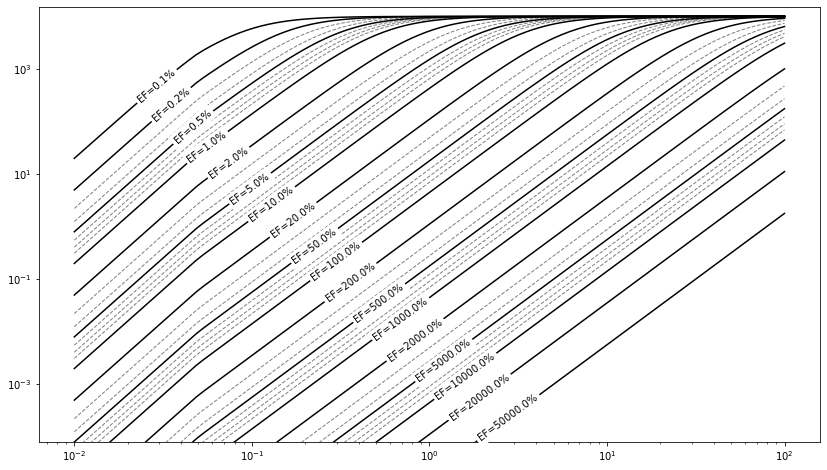

In [52]:
tA=3/100
rhoA=5
rhoG=2.8
ML = 10000

dl=0.05
main=np.array([1,2,5])
EF= np.concatenate((main*0.001,main*0.01,main*0.1))
d5= np.power(10,np.linspace(-2,2,100))
Me = np.array([compute_sample_mass(EF_i,d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,ML=ML,verbose=False) for EF_i in EF])
sub=np.array([3,4,6,7,8])
EF_sub = np.concatenate((sub*0.001,sub*0.01,sub*0.1,sub,sub*10))
Me_sub = np.array([compute_sample_mass(EF_i,d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,ML=ML,verbose=False) for EF_i in EF_sub])
EF_more = np.concatenate((main,main*10,main*100))
Me_more = np.array([compute_sample_mass(EF_i,d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,ML=ML,verbose=False) for EF_i in EF_more])
for EF_i,Me_i in zip(EF_sub,Me_sub):
    plt.loglog(d5,Me_i,"--",color="gray",linewidth=1)
for EF_i,Me_i in zip(EF,Me):
    plt.loglog(d5,Me_i,"k-")
for EF_i,Me_i in zip(EF,Me_more):
    plt.loglog(d5,Me_i,"k-")

Me_min = np.min(Me)
Me_max = np.max(Me)
plt.ylim(Me_min,1.5*Me_max) 
plt.gcf().set_size_inches((14,8))

for EF_i,Me_i in zip(EF,Me):
    Me_0 = np.min(Me_i)
    tau = 0.45
    label_Me = tau*np.log10(ML) + (1-tau)*np.log10(Me_0)
    node_0 = np.where(np.log10(Me_i)>label_Me)[0][0]
    
    x,y = d5[node_0:node_0+2],Me_i[node_0:node_0+2]
    x_label = np.power(10,0.5*np.sum(np.log10(x)))
    y_label = np.power(10,0.5*np.sum(np.log10(y)))
    log_dx,log_dy = (np.log10(x[1])-np.log10(x[0]),np.log10(y[1])-np.log10(y[0]))

    aspect_ratio = compute_aspect_ratio(plt.gca())
    rot_angle = np.degrees(np.arctan2(log_dy,aspect_ratio*log_dx))
    plt.annotate("EF={:.1f}%".format(EF_i*100),
                 xy=(x_label,y_label),textcoords="offset pixels",xytext=(0,0),
                 bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=None, lw=0),
                 ha="center", va="center", rotation=rot_angle)

for EF_i,Me_i in zip(EF_more,Me_more):
    Me_0 = np.min(Me_i)
    tau = 0.45
    label_Me = tau*np.log10(ML) + (1-tau)*np.log10(Me_0)
    node_0 = np.where(np.log10(Me_i)>label_Me)[0][0]
    
    x,y = d5[node_0:node_0+2],Me_i[node_0:node_0+2]
    x_label = np.power(10,0.5*np.sum(np.log10(x)))
    y_label = np.power(10,0.5*np.sum(np.log10(y)))
    log_dx,log_dy = (np.log10(x[1])-np.log10(x[0]),np.log10(y[1])-np.log10(y[0]))

    aspect_ratio = compute_aspect_ratio(plt.gca())
    rot_angle = np.degrees(np.arctan2(log_dy,aspect_ratio*log_dx))
    plt.annotate("EF={:.1f}%".format(EF_i*100),
                 xy=(x_label,y_label),textcoords="offset pixels",xytext=(0,0),
                 bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=None, lw=0),
                 ha="center", va="center", rotation=rot_angle)

In [206]:
def sampling_plan_EF(tA, rhoA, rhoG, dl, ML= None, dmin=None, dmax=None, ax= None, verbose= True ):
    plt_ax = ax if ax is not None else plt.gca()
    
    main=np.array([1,2,5])
    EF= np.concatenate((main*0.001,main*0.01,main*0.1))
    dmin = dmin if dmin is not None else 10**-3
    dmax = dmax if dmax is not None else 10**2
    d5= np.power(10,np.linspace(np.log10(dmin), np.log10(dmax), 100))
    Me = np.array([compute_sample_mass(EF_i,d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,ML=ML,verbose=False) for EF_i in EF])
    sub=np.array([3,4,6,7,8])
    EF_sub = np.concatenate((sub*0.001,sub*0.01,sub*0.1,sub,sub*10))
    Me_sub = np.array([compute_sample_mass(EF_i,d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,ML=ML,verbose=False) for EF_i in EF_sub])
    EF_more = np.concatenate((main,main*10,main*100))
    Me_more = np.array([compute_sample_mass(EF_i,d5=d5,tA=tA,rhoA=rhoA,rhoG=rhoG,dl=dl,ML=ML,verbose=False) for EF_i in EF_more])
    for EF_i,Me_i in zip(EF_sub,Me_sub):
        plt_ax.loglog(d5,Me_i,"--",color="gray",linewidth=1)
    for EF_i,Me_i in zip(EF,Me):
        plt_ax.loglog(d5,Me_i,"k-")
    for EF_i,Me_i in zip(EF,Me_more):
        plt_ax.loglog(d5,Me_i,"k-")

    Me_min = np.min(Me)
    Me_max = np.max(Me)
    plt_ax.set_ylim(Me_min,1.5*Me_max) 
    plt_ax.set_xlim(xmin=dmin, xmax=dmax)

    for EF_i,Me_i in zip(EF,Me):
        Me_0 = np.min(Me_i)
        tau = 0.45
        label_Me = tau*np.log10(ML) + (1-tau)*np.log10(Me_0)
        node_0 = np.where(np.log10(Me_i)>label_Me)[0][0]

        x,y = d5[node_0:node_0+2],Me_i[node_0:node_0+2]
        x_label = np.power(10,0.5*np.sum(np.log10(x)))
        y_label = np.power(10,0.5*np.sum(np.log10(y)))
        log_dx,log_dy = (np.log10(x[1])-np.log10(x[0]),np.log10(y[1])-np.log10(y[0]))

        aspect_ratio = compute_aspect_ratio(plt_ax)
        rot_angle = np.degrees(np.arctan2(log_dy,aspect_ratio*log_dx))
        plt_ax.annotate("EF={:.1f}%".format(EF_i*100),
                     xy=(x_label,y_label),textcoords="offset pixels",xytext=(0,0),
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=None, lw=0),
                     ha="center", va="center", rotation=rot_angle)

    for EF_i,Me_i in zip(EF_more,Me_more):
        Me_0 = np.min(Me_i)
        tau = 0.45
        label_Me = tau*np.log10(ML) + (1-tau)*np.log10(Me_0)
        node_0 = np.where(np.log10(Me_i)>label_Me)[0][0]

        x,y = d5[node_0:node_0+2],Me_i[node_0:node_0+2]
        x_label = np.power(10,0.5*np.sum(np.log10(x)))
        y_label = np.power(10,0.5*np.sum(np.log10(y)))
        log_dx,log_dy = (np.log10(x[1])-np.log10(x[0]),np.log10(y[1])-np.log10(y[0]))

        aspect_ratio = compute_aspect_ratio(plt_ax)
        rot_angle = np.degrees(np.arctan2(log_dy,aspect_ratio*log_dx))
        plt_ax.annotate("EF={:.1f}%".format(EF_i*100),
                     xy=(x_label,y_label),textcoords="offset pixels",xytext=(0,0),
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=None, lw=0),
                     ha="center", va="center", rotation=rot_angle)

    plt_ax.set_title("Plan d'échantillonnage")
    plt_ax.set_xlabel("d5% de l'échantillon (cm)")
    plt_ax.set_ylabel("Masse de l'échantillon (g)")

    plt_ax.axhline(ML,label="Masse du lot")
    plt_ax.axvline(dl,linestyle="--",label="Maille de libération")
    leg = plt_ax.legend(loc="lower left",bbox_to_anchor=(1,0.5))
    
    return plt_ax

def sampling_plan(steps, initial_mass, initial_size, tA, rhoA, rhoG, dl, ax= None, verbose= True, **kargs ):
    """steps: array of tuple [("type",value)]
       initial_mass: g, masse du lot
       initial_size: cm, d5% pour le matériel de départ"""
    plt_ax = ax if ax is not None else plt.gca()
    
    sampling_plan_EF(tA= tA, rhoA= rhoA, rhoG= rhoG, dl= dl, dmax= initial_size*1.5, ML= initial_mass, ax= plt_ax)
    
    mass_step = [initial_mass]
    size_step = [initial_size]
    EF = [0]
    
    if verbose:
        print("Plan d'échantillonnage pour les paramètres suivant de minerais")
        print("  Teneur globale en minerais : ",tA)
        print("  Masse volumique du minerais : ",rhoA)
        print("  Masse volumique de la gangue : ",rhoG)

        print("  Masse du lot (g) : ",ML)
        print("  Maille de libération (cm) : ",dl)
    if verbose: print("Étape {}: {:.2E} g de taille d5 {:.2E} cm".format(0, initial_mass, initial_size))
    for i,(step_type, value) in enumerate(steps):
        if step_type == "grind":
            if verbose: print("  Étape {}: broyer à une taille de {:.2E} cm".format(i+1,value))
            size_step += [value]
            mass_step += [mass_step[-1]]
            EF += [0]
        elif step_type == "sample":
            if verbose: print("  Étape {}: échantillonner {:.2E} g".format(i+1,value))
            size_step += [size_step[-1]]
            mass_step += [value]
            EF += [compute_EF(value, size_step[-1], tA= tA, rhoA= rhoA, rhoG= rhoG, dl= dl, verbose=False, **kargs )]
            plt_ax.annotate("{:.1f}%".format(EF[-1]*100), xy= (size_step[-1], mass_step[-1]), xytext= (size_step[-1]*1.35, mass_step[-1]),bbox=dict(boxstyle="round4", fc="white", ec="k", lw=2), zorder=10)
            if verbose: print("  -> L'erreur fondamentale augmente de {:.2f} %".format(EF[-1]*100))
        plt_ax.annotate("{:}".format(i+1), xy= (size_step[-1], mass_step[-1]), xytext= (size_step[-1], mass_step[-1]),
                        bbox=dict(boxstyle="circle,pad=0.3", fc="white", ec="k", lw=1), zorder=10)
    plt_ax.plot(size_step,mass_step,"or-", label="Sampling plan", zorder=5)
    
    print("\nErreur fondamentale cumulée: {:.1f} %".format(sum(EF)*100))
    
    pire_etape = np.argmax(EF)
    print("L'étape contribuant le plus à l'erreur est l'étape {} : +{:.2f} %".format(pire_etape,EF[pire_etape]*100))
    

Plan d'échantillonnage pour les paramètres suivant de minerais
  Teneur globale en minerais :  0.03
  Masse volumique du minerais :  5
  Masse volumique de la gangue :  2.8
  Masse du lot (g) :  100000
  Maille de libération (cm) :  0.05
Étape 0: 1.00E+05 g de taille d5 2.00E+02 cm
  Étape 1: broyer à une taille de 2.00E+01 cm
  Étape 2: échantillonner 1.00E+04 g
  -> L'erreur fondamentale augmente de 89.31 %
  Étape 3: broyer à une taille de 5.00E+00 cm
  Étape 4: échantillonner 1.00E+03 g
  -> L'erreur fondamentale augmente de 49.93 %
  Étape 5: broyer à une taille de 1.00E+00 cm
  Étape 6: échantillonner 1.00E+01 g
  -> L'erreur fondamentale augmente de 66.78 %
  Étape 7: broyer à une taille de 1.00E-01 cm
  Étape 8: échantillonner 1.00E-01 g
  -> L'erreur fondamentale augmente de 37.55 %
  Étape 9: broyer à une taille de 1.00E-02 cm
  Étape 10: échantillonner 1.00E-02 g
  -> L'erreur fondamentale augmente de 4.47 %

Erreur fondamentale cumulée: 248.0 %
L'étape contribuant le plus à

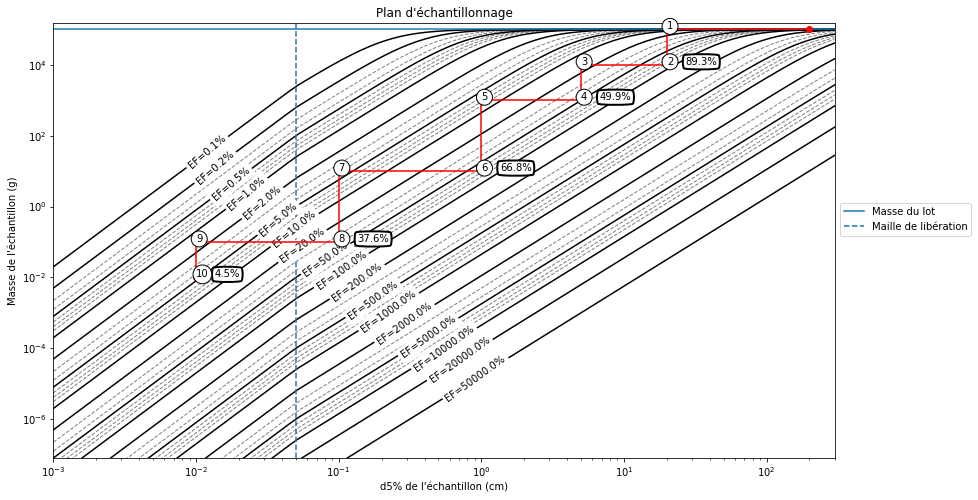

In [208]:
tA=3/100
rhoA=5
rhoG=2.8
dl=0.05

ML= 10**5
d5= 200
steps=[
    ("grind", 20),
    ("sample",10**4),
    ("grind", 5),
    ("sample",10**3),
    ("grind", 1),
    ("sample",10**1),
    ("grind", 0.1),
    ("sample",10**-1),
    ("grind", 0.01),
    ("sample",10**-2)
]
sampling_plan(steps, initial_mass= ML, initial_size= d5,tA= tA, rhoA= rhoA, rhoG= rhoG, dl= dl)
plt.gcf().set_size_inches((14,8))

Plan d'échantillonnage pour les paramètres suivant de minerais
  Teneur globale en minerais :  0.01
  Masse volumique du minerais :  1.5
  Masse volumique de la gangue :  1.5
  Masse du lot (g) :  43000000
  Maille de libération (cm) :  0.05
Étape 0: 4.30E+07 g de taille d5 2.00E+02 cm
  Étape 1: broyer à une taille de 2.00E+01 cm
  Étape 2: échantillonner 1.00E+06 g
  -> L'erreur fondamentale augmente de 8.62 %
  Étape 3: broyer à une taille de 5.00E+00 cm
  Étape 4: échantillonner 1.00E+03 g
  -> L'erreur fondamentale augmente de 48.17 %
  Étape 5: broyer à une taille de 1.00E+00 cm
  Étape 6: échantillonner 1.00E+01 g
  -> L'erreur fondamentale augmente de 64.43 %
  Étape 7: broyer à une taille de 2.00E-01 cm
  Étape 8: échantillonner 1.00E-01 g
  -> L'erreur fondamentale augmente de 86.17 %
  Étape 9: broyer à une taille de 5.00E-02 cm
  Étape 10: échantillonner 1.00E-02 g
  -> L'erreur fondamentale augmente de 48.17 %

Erreur fondamentale cumulée: 255.6 %
L'étape contribuant le pl

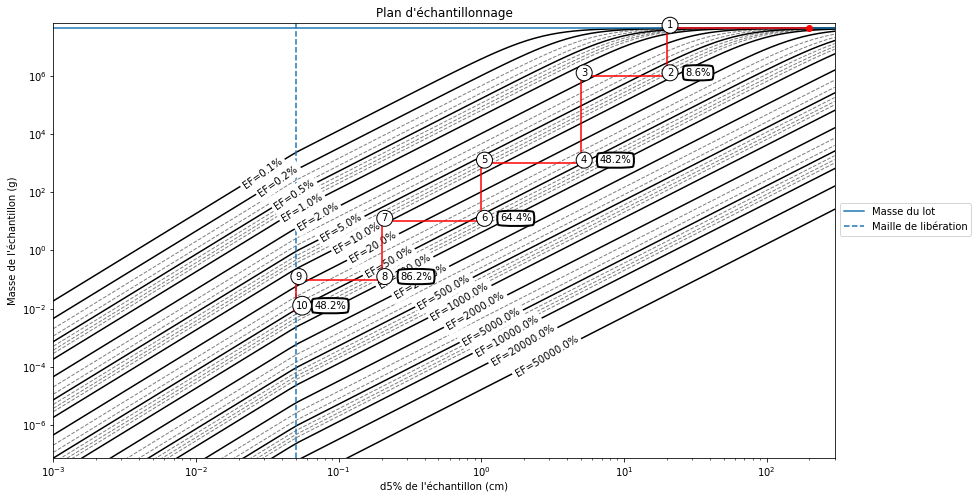

In [209]:

ML= 43*10**6
initial_size= 200
steps=[
    ("grind", 20),
    ("sample",10**6),
    ("grind", 5),
    ("sample",10**3),
    ("grind", 1),
    ("sample",10**1),
    ("grind", 0.2),
    ("sample",10**-1),
    ("grind", 0.05),
    ("sample",10**-2)
]
sampling_plan(steps, initial_mass= ML, initial_size= initial_size,tA= 1/100, rhoA= 1.5, rhoG= 1.5, dl=0.05)
plt.gcf().set_size_inches((14,8))

In [217]:
@interact(grind_size= widgets.FloatLogSlider(value=1,min=-2,max=2,step=0.1,continuous_update=False),
          sample_mass= widgets.FloatLogSlider(value=4,min=-3,max=5,step=0.1,continuous_update=False))
def interact_sampling_plan(grind_size, sample_mass):
    tA=3/100
    rhoA=5
    rhoG=2.8
    dl=0.05

    ML= 10**6
    d5= 200
    steps=[
        ("grind", 10),
        ("sample",5*10**5),
        ("grind", grind_size),
        ("sample",sample_mass),
        ("grind", 0.01),
        ("sample",10**-2)
    ]
    sampling_plan(steps, initial_mass= ML, initial_size= d5,tA= tA, rhoA= rhoA, rhoG= rhoG, dl= dl,verbose=False)
    plt.gcf().set_size_inches((14,8))
    
    print("masse broyée à l'étape 3: {} kg".format(5*10**5/1000))
    print("masse broyée à l'étape 5: {:.2f} g".format(sample_mass))

interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='grind_size', max=2.0, mi…

**A vous de jouer** : trouvez comment maintenir une erreur fondamentale total sous la barre des 25 %